In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Layer, Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation, 
    Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.initializers import TruncatedNormal
from einops import rearrange
import pickle
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [2]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [4]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [5]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


In [7]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")
print(y_train.shape, y_test.shape)
# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128) (569, 128, 128)
(2272, 128, 128, 1) (569, 128, 128, 1)


In [8]:
def plot_images(X_test, y_test, model_mask, selected_indices):
    for i in selected_indices:
        plt.figure(figsize=(15,5))

        # orignal image
        plt.subplot(1,4,1)
        plt.imshow(X_test[i].squeeze())
        plt.title("Orignal Image")
        plt.axis("off")

        # Orignal Mask
        plt.subplot(1,4,2)
        plt.imshow(y_test[i].squeeze(), cmap='viridis')
        plt.title('Orignal Mask')
        plt.axis("off")

        # Model Mask
        plt.subplot(1,4,3)
        plt.imshow(model_mask[i].squeeze(), cmap='viridis')
        plt.title('Model Mask')
        plt.axis("off")
    plt.show()

In [9]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt

In [10]:
def calculate_IOU(y_true, y_pred, threshold = 0.5):
    y_pred = (y_pred > threshold).astype(np.uint8) # Binarize predictions
    intersection = np.sum(y_true * y_pred, axis = (1,2)) # Per image
    union = np.sum(y_true + y_pred, axis = (1,2)) - intersection # Per image
    iou = np.mean(intersection / (union + 1e-6)) # Avoid division by zero
    return iou

def Training_IoU(model, X_train, y_train):
    train_predictions = model.predict(X_train)
    train_predictions = train_predictions.squeeze()  # Shape:(height, width)
    y_train = y_train.squeeze()  # Shape:, height, width)

    train_iou = calculate_IOU(y_train, train_predictions)
    return train_iou

def Testing_IoU (model, X_test, y_test):
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.squeeze()  # Shape: ( height, width)
    y_test = y_test.squeeze()  # Shape: (batch_size, height, width)

    test_iou = calculate_IOU(y_test, test_predictions)
    return test_iou

In [11]:
def trained_history(path, trained_model, algo, X_train, y_train, X_test, y_test):
  with open(path,'rb') as file:
    loaded_history = pickle.load(file)
  train_accuracy = loaded_history['accuracy']
  train_loss = loaded_history['loss']

  val_accuracy = loaded_history['val_accuracy']
  val_loss = loaded_history['val_loss']

  data = {
    'Algorithm': [algo[0], algo[1]],
    'Accuracy': [train_accuracy[-1], val_accuracy[-1]],
    'Loss': [train_loss[-1], val_loss[-1]],
    'IOU': [Training_IoU(trained_model,X_train, y_train), Testing_IoU(trained_model,X_test, y_test)]
  }

  df = pd.DataFrame(data)

  return df

In [12]:
config = {}
config["image_size"] = 128
config["num_channels"] = 3
config["num_layers"] = 12
config["hidden_dim"] = 512
config["mlp_dim"] = 3072
config["num_heads"] = 4
config["dropout_rate"] = 0.1
#config["num_patches"] = 256
config["patch_size"] = 16
config["num_patches"] = (config["image_size"]**2) // (config["patch_size"]**2)

In [13]:
@register_keras_serializable()
class Create_Patches(Layer):
    def __init__(self, patch_size, channles=3):
        super(Create_Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
        

In [14]:
batch = X_train
patches = Create_Patches(config["patch_size"])(batch)
patches.shape

TensorShape([2272, 64, 768])

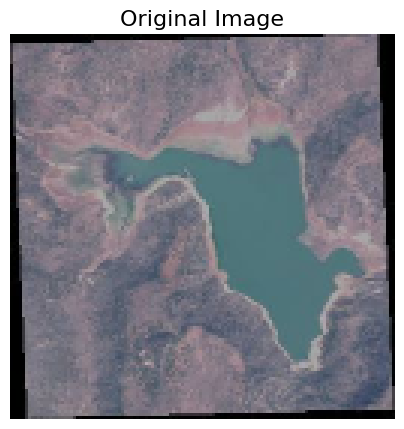

In [347]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].astype("uint8"))
plt.title("Original Image", fontsize=16)
plt.axis("off")
plt.show()

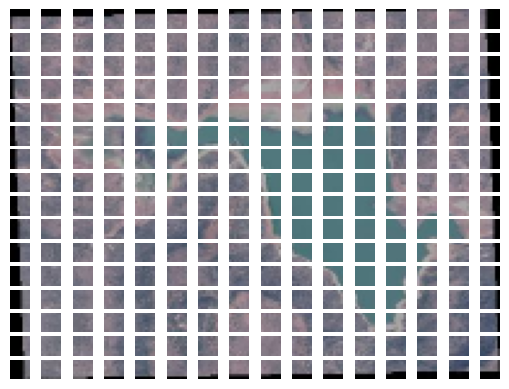

In [348]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (config["patch_size"], config["patch_size"], 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

In [15]:
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [540]:
data = (patches.shape[1], patches.shape[2])
print(data)
embeddings = LinearEmbedding(config["num_patches"], config["hidden_dim"])(patches)
embeddings.shape

(64, 768)


TensorShape([2272, 64, 512])

In [16]:
class MLP(Layer):
    def __init__(self, mlp_dim, hidden_dim, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(mlp_dim, activation=tf.nn.gelu)
        self.dense2 = Dense(hidden_dim)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [354]:
mlp = MLP(config["mlp_dim"],config["hidden_dim"])(patches[:32])
mlp.shape

TensorShape([32, 256, 512])

In [17]:
class TransformerEncoder(Layer):
    def __init__(self, num_heads, hidden_dim, mlp_dim, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        
        self.layer_norm1 = LayerNormalization()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.add1 = Add()
        
        self.layer_norm2 = LayerNormalization()
        self.mlp = MLP(config["mlp_dim"],config["hidden_dim"])
        self.add2 = Add()

    def call(self, inputs):
        # First sub-layer: Multi-Head Self-Attention
        skip1 = inputs
        x = self.layer_norm1(inputs)
        x = self.mha(x, x)
        x = self.add1([x, skip1])
        
        # Second sub-layer: Feed Forward Network (MLP)
        skip2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = self.add2([x, skip2])
        
        return x

In [543]:
x = TransformerEncoder(config["num_heads"], config["hidden_dim"], config["mlp_dim"])(embeddings[:32])
print(x.shape)

(32, 64, 512)


In [18]:
def conv_block(x, num_filters, kernel_size=3):
    x = Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def deconv_block(x, num_filters):
    x = Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [20]:
def attention_block(g, x, num_filters):
    shape_g = K.int_shape(g)  # Shape of upsampled feature map (decoder output)
    shape_x = K.int_shape(x)  # Shape of skip connection (encoder output)

    # Upsample skip connection (x) to match the spatial dimensions of g
    x_upsampled = UpSampling2D(size=(shape_g[1] // shape_x[1], shape_g[2] // shape_x[2]))(x)

    # Apply 1x1 convolutions to both g and upsampled x
    Wg = Conv2D(num_filters, (1, 1), strides=1, padding='same')(g)
    Wg = BatchNormalization()(Wg)

    Wx = Conv2D(num_filters, (1, 1), strides=1, padding='same')(x_upsampled)
    Wx = BatchNormalization()(Wx)

    # Add g and upsampled x
    concat_xg = Add()([Wg, Wx])
    relu_act_xg = Activation('relu')(concat_xg)

    # Compute attention weights
    psi = Conv2D(1, (1, 1), padding='same')(relu_act_xg)
    sig_act_xg = Activation('sigmoid')(psi)

    # Apply attention weights to upsampled skip connection
    out = Multiply()([sig_act_xg, x_upsampled])

    return out

In [44]:
def ViT_UNET(input_shape=(128, 128, 3), cf = config):
    inputs = Input(input_shape)
    
    patches = Create_Patches(cf["patch_size"])(inputs)

    x = LinearEmbedding(cf["num_patches"], cf["hidden_dim"])(patches)

    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"] + 1, 1):
        x = TransformerEncoder(config["num_heads"], config["hidden_dim"], config["mlp_dim"])(x)

        if i in skip_connection_index:
            skip_connections.append(x)

    z3, z6, z9, z12 = skip_connections
    #print(z3.shape, z6.shape, z9.shape, z12.shape)

    z0 = Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    
    # Compute height and width of feature maps
    patch_grid_size = int(tf.sqrt(float(cf["num_patches"])))  # Assuming square patches
    feature_channels = cf["hidden_dim"]
    z3 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z3)
    z6 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z6)
    z9 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z9)
    z12 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z12)
    print(z0.shape, z3.shape, z6.shape, z9.shape, z12.shape)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    outputs = Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    return Model(inputs, outputs, name="UNETR_2D")

In [45]:
model = ViT_UNET()
model.summary()

(None, 128, 128, 3) (None, 8, 8, 512) (None, 8, 8, 512) (None, 8, 8, 512) (None, 8, 8, 512)


Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ create__patches_3         │ (None, None, 768)      │              0 │ input_layer_2[0][0]    │
│ (Create_Patches)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ linear_embedding_2        │ (None, 64, 512)        │        426,496 │ create__patches_3[0][… │
│ (LinearEmbedding)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_24    │ (None, 64, 512)        │      7,352,320 │ linear_embedding_2[0]… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_25    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_26    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_27    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_28    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_29    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_30    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_2… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_31    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_3… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_32    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_3… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_33    │ (None, 64, 512)        │      7,352,320 │ transformer_encoder_3… │
│ (TransformerEncoder)      │                        │                │                        │
├──────────────────────

 Total params: 106,059,201 (404.58 MB)

 Trainable params: 106,052,289 (404.56 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [46]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5), # clipvalue=0.5
    loss= "binary_crossentropy",
    metrics=["accuracy"]  # Include both IoU and Dice metrics
)

In [47]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 8, restore_best_weights = True)

In [48]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6, verbose=1
)

In [49]:
checkpoint_callback = ModelCheckpoint(
    filepath='vit_unet.keras',
    save_best_only=True,
    monitor='val_loss',  # You can adjust this to the desired metric
    mode='min',          # Use 'min' for loss and 'max' for accuracy
    verbose=1
)

In [50]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    #batch_size = 16,
    callbacks = [lr_scheduler,checkpoint_callback, c1]
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.7080 - loss: 0.5751
Epoch 1: val_loss improved from inf to 20.05584, saving model to vit_unet.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 145s 990ms/step - accuracy: 0.7084 - loss: 0.5746 - val_accuracy: 0.4071 - val_loss: 20.0558 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.7682 - loss: 0.4914
Epoch 2: val_loss improved from 20.05584 to 2.61592, saving model to vit_unet.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 64s 903ms/step - accuracy: 0.7682 - loss: 0.4914 - val_accuracy: 0.4584 - val_loss: 2.6159 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.7808 - loss: 0.4736
Epoch 3: val_loss improved from 2.61592 to 1.39911, saving model to vit_unet.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 64s 900ms/step - accuracy: 0.7808 - loss: 0.4735 - val_accuracy: 0.4412 - val_loss: 1.3991 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy:

In [51]:
with open('/kaggle/working/vit_unet_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [58]:
trained_model = load_model('/kaggle/working/vit_unet.keras')

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'UNETR_2D', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 128, 128, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': None, 'class_name': 'Create_Patches', 'config': {'patch_size': 16, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Custom>Create_Patches', 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'create__patches_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'LinearEmbedding', 'config': {'name': 'linear_embedding_2', 'num_patches': 64, 'projection_dim': 512, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'LinearEmbedding', 'build_config': {'input_shape': [None, None, 768]}, 'name': 'linear_embedding_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 768], 'dtype': 'float32', 'keras_history': ['create__patches_3', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_24', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['linear_embedding_2', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_25', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_24', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_26', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_25', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_27', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_26', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_28', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_27', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_29', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_28', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_30', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_29', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_31', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_30', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_32', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_31', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_33', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_32', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'target_shape': [8, 8, 512]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'reshape_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_32', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_34', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_33', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 512, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}, 'name': 'conv2d_transpose_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 512], 'dtype': 'float32', 'keras_history': ['reshape_13', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'TransformerEncoder', 'config': {'name': 'transformer_encoder_35', 'num_heads': 4, 'hidden_dim': 512, 'mlp_dim': 3072, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}}, 'registered_name': 'TransformerEncoder', 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'transformer_encoder_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_34', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'conv2d_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'target_shape': [8, 8, 512]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'reshape_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_35', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_40', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'batch_normalization_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['conv2d_50', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 512, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}, 'name': 'conv2d_transpose_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 512], 'dtype': 'float32', 'keras_history': ['reshape_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_40', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'activation_40', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_40', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'target_shape': [8, 8, 512]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'reshape_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 16, 512], [None, 16, 16, 512]]}, 'name': 'concatenate_8', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_8', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['activation_40', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}, 'name': 'conv2d_transpose_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 512], 'dtype': 'float32', 'keras_history': ['reshape_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 1024]}, 'name': 'conv2d_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 1024], 'dtype': 'float32', 'keras_history': ['concatenate_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_41', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'batch_normalization_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['conv2d_51', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_43', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'batch_normalization_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_53', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_41', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'activation_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_43', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'activation_43', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'target_shape': [8, 8, 512]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 512]}, 'name': 'reshape_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 512], 'dtype': 'float32', 'keras_history': ['transformer_encoder_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'conv2d_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['activation_41', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_transpose_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 256], 'dtype': 'float32', 'keras_history': ['activation_43', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 512]}, 'name': 'conv2d_transpose_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 512], 'dtype': 'float32', 'keras_history': ['reshape_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_42', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'batch_normalization_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['conv2d_52', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_57', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 128]}, 'name': 'conv2d_57', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_42', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'activation_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_42', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_44', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'batch_normalization_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_54', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_47', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 128]}, 'name': 'batch_normalization_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 128], 'dtype': 'float32', 'keras_history': ['conv2d_57', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'conv2d_transpose_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['activation_42', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_44', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'activation_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_47', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 128]}, 'name': 'activation_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 32, 256], [None, 32, 32, 256]]}, 'name': 'concatenate_9', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_10', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['activation_44', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 128]}, 'name': 'conv2d_transpose_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 128], 'dtype': 'float32', 'keras_history': ['activation_47', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 512]}, 'name': 'conv2d_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 512], 'dtype': 'float32', 'keras_history': ['concatenate_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_58', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_58', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_45', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'batch_normalization_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_55', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_48', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'batch_normalization_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 128], 'dtype': 'float32', 'keras_history': ['conv2d_58', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_45', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'activation_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_48', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'activation_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_56', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_56', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['activation_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 128]}, 'name': 'conv2d_transpose_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 128], 'dtype': 'float32', 'keras_history': ['activation_48', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'batch_normalization_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_56', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_59', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_59', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_46', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'activation_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'batch_normalization_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_59', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_transpose_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['activation_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_49', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'activation_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_49', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 128], [None, 64, 64, 128]]}, 'name': 'concatenate_10', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_13', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['activation_49', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_60', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'conv2d_60', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['concatenate_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'target_shape': [128, 128, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'reshape_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'batch_normalization_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_60', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_62', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'conv2d_62', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['reshape_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'activation_50', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'batch_normalization_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_62', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_61', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_61', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['activation_50', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_52', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'activation_52', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'batch_normalization_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_61', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_63', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_63', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['activation_52', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_51', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'activation_51', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_51', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'batch_normalization_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_63', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_17', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_transpose_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['activation_51', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_53', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'activation_53', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_53', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 128, 128, 64], [None, 128, 128, 64]]}, 'name': 'concatenate_11', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_17', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['activation_53', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_64', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}, 'name': 'conv2d_64', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['concatenate_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'batch_normalization_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_64', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_54', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'activation_54', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_54', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_65', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_65', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['activation_54', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'batch_normalization_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_65', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_55', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'activation': 'relu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'activation_55', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_55', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_66', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 139086657394272}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_66', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['activation_55', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_2', 0, 0]], 'output_layers': [['conv2d_66', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 2.429999995001708e-06, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': 0.5, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'binary_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: <class '__main__.Create_Patches'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'Create_Patches', 'config': {'patch_size': 16, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Custom>Create_Patches', 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'create__patches_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {}}]}.

Exception encountered: Error when deserializing class 'Create_Patches' using config={'patch_size': 16, 'trainable': True, 'dtype': 'float32'}.

Exception encountered: Create_Patches.__init__() got an unexpected keyword argument 'trainable'

In [386]:
#model.save("vit_unet.keras")

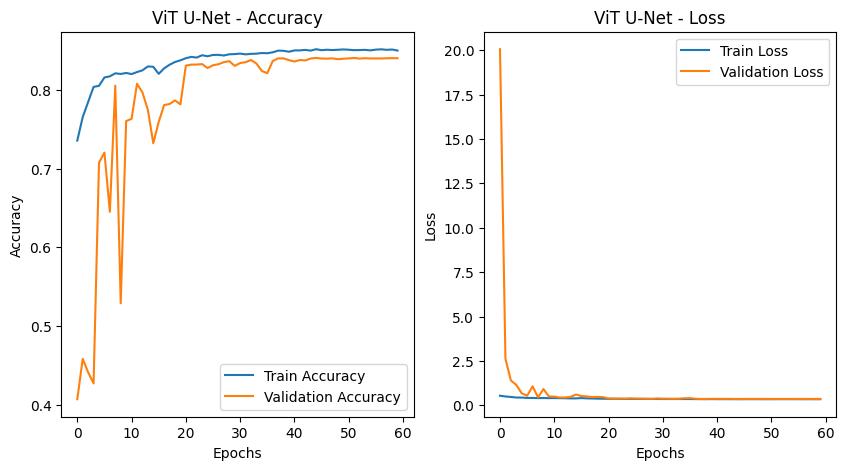

In [52]:
plot_training_history(history, "ViT U-Net")

In [53]:
model_matrix = trained_history('/kaggle/working/vit_unet_history.pkl',model, ['ViT-UNet (Training)', 'ViT-UNet (Validation)'], X_train, y_train, X_test, y_test)
print(model_matrix)

71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step
               Algorithm  Accuracy      Loss       IOU
0    ViT-UNet (Training)   0.84992  0.342805  0.654464
1  ViT-UNet (Validation)   0.84020  0.356427  0.622223


In [54]:
mask = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step


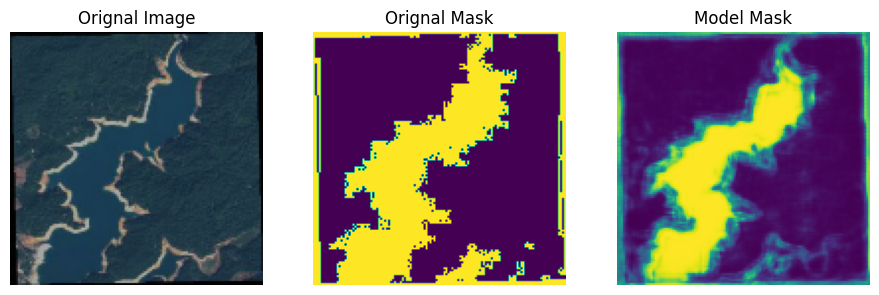

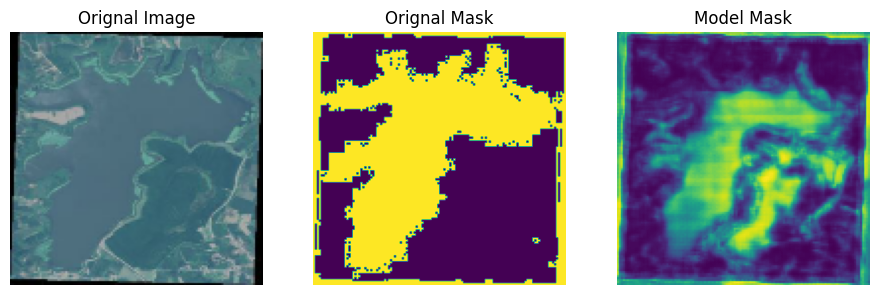

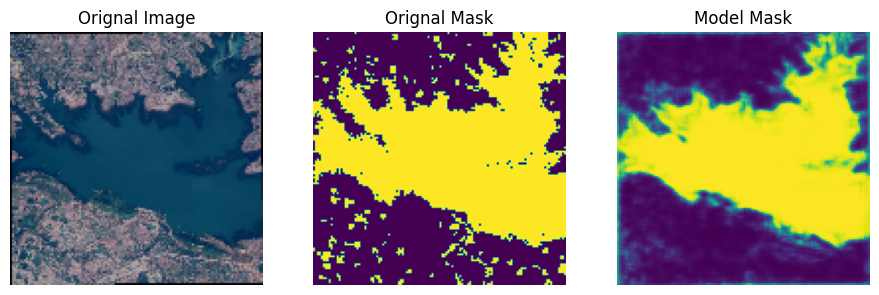

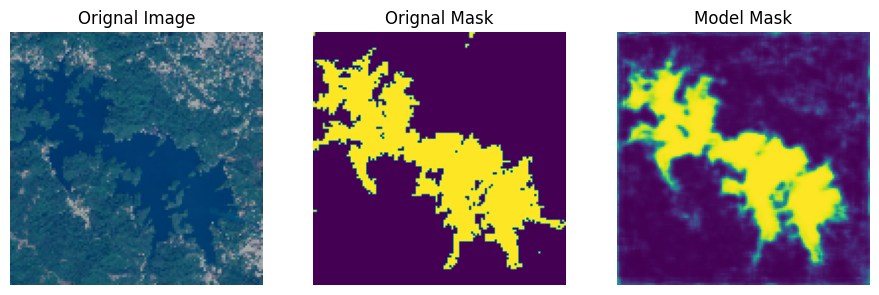

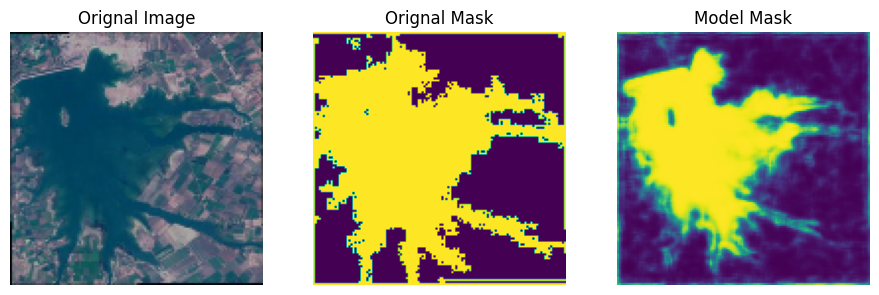

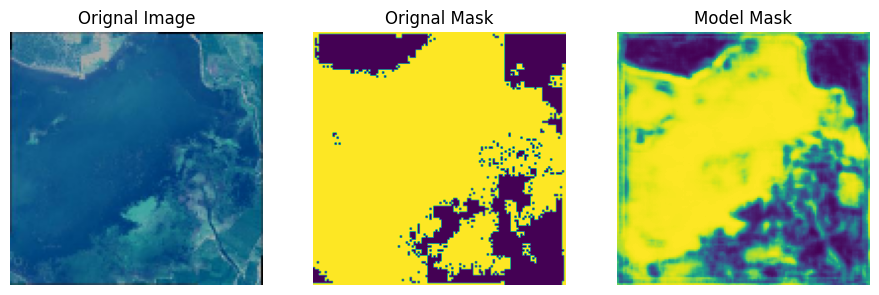

In [55]:
plot_images(X_test, y_test, mask, selected_indices = [1, 4, 22, 25, 46, 95])